# Capstone Project - Predicting the Severity of the Collision
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to predict the severity of an accident based on the input such as weather condition, road condition, location etc. This report is targetted to help drivers to get early warnings on the serverity codes for them take conscious decisions.

We will try to understand the relationship between various attributes and identify which ones are going to be more impactful in identifying the factors influencing the severity of the accident.


## Data <a name="data"></a>

As described in the problem statement, we need the dataset correspoding to previoys accidents to understand, analyze and identify the relations between various factors involved in the collisions.

I am going to use the dataset from Seattle transport records that has all required deatails that are gathered since 2004. 

### Data Analysis <a name="analysis"></a>

In [203]:
# Load required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
%matplotlib inline

In [204]:
# Read the data
path='https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'
df= pd.read_csv(path)
df.shape

(194673, 38)

In [101]:
# Pick relevant features for further analysis
df_coll = df.copy()
df_coll = df[['SEVERITYCODE','ADDRTYPE','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT',
              'PEDCYLCOUNT','VEHCOUNT','JUNCTIONTYPE','SDOT_COLCODE','WEATHER',
              'ROADCOND','LIGHTCOND','ST_COLCODE','HITPARKEDCAR']]

In [98]:
# Clean up the null records.
df_coll['ADDRTYPE'].fillna('Unknown', inplace=True)
df_coll['COLLISIONTYPE'].fillna('Unknown', inplace=True)
df_coll['JUNCTIONTYPE'].fillna('Unknown', inplace=True)
df_coll['WEATHER'].fillna('Unknown',inplace=True)
df_coll['ROADCOND'].fillna('Unknown',inplace=True)
df_coll['LIGHTCOND'].fillna('Unknown',inplace=True)
df_coll['ST_COLCODE'].fillna(-1,inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [9]:
# Function that returns the severity counts for a given feature.
def getseverities(feature):      
    df_temp = pd.concat([df_coll[[feature,'SEVERITYCODE']], pd.get_dummies(df_coll['SEVERITYCODE'])], axis=1)
    df_temp.drop('SEVERITYCODE', axis = 1, inplace=True)    
    df_temp_cnt = df_temp.groupby([feature],as_index=True).sum().astype(int)   
    return df_temp_cnt
#Usage
#df_test = getseverities('ADDRTYPE')
#df_test

In [10]:
# Function that returns the severity counts in percentages for a given feature
def getseveritiesinpct(feature):     
    df_temp = getseverities(feature)  
    df_temp_pct = df_temp.copy()
    for i in range(len(df_temp.columns)):
        df_temp_pct[df_temp.columns[i]] =(df_temp[df_temp.columns[i]].values/df_temp.sum(axis=1)).multiply(100).round(decimals=2)
    return df_temp_pct
#Usage
#df_test = getseveritiesinpct('ADDRTYPE').astype(str)+'%'
#df_test

In [11]:
#Function that returns counts in one column.
def getcntsinonecol(feature):
    df_temp=getseverities(feature)
    df_sev = pd.DataFrame()
    #df_sev = df_temp[[feature]]
    for i in range(len(df_temp.columns)):
        df_sev1 = pd.DataFrame(df_temp[df_temp.columns[i]])
        df_sev1.rename(columns={df_sev1.columns[0]:'COUNT'}, inplace=True)
        df_sev1['SEVERITY']=str(i+1)
        df_sev = df_sev.append(df_sev1, ignore_index=False)
    return df_sev
#Usage
#df_test = getcntsinonecol('ADDRTYPE')
#df_test

Now, let us visualize relations between some of the features and the severity code:

In general, severity of an accident is influenced by the humans involved in the collision. But, let me  check whether given data supports that intution

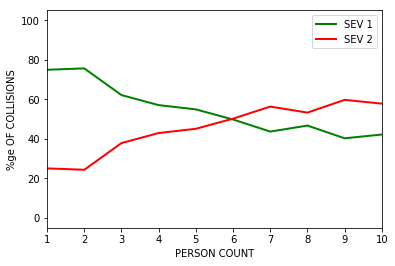

In [104]:
# Visualize the total people impacted in the collision in percentages and the severity
df_temp=getseveritiesinpct('PERSONCOUNT')
x1 = df_temp.index
y1=df_temp.loc[:,df_temp.columns[0]]
y2=df_temp.loc[:,df_temp.columns[1]]
plt.plot(x1, y1, label = "SEV 1", color='green', linewidth=2)
plt.plot(x1, y2, label = "SEV 2", color='red', linewidth=2)
plt.xlim([1,10])
plt.xlabel("PERSON COUNT")
plt.ylabel("%ge OF COLLISIONS")
plt.legend()

I want to check whether collision type has a role to play in determining the severity code. Let me draw some visulaiztion to confirm.

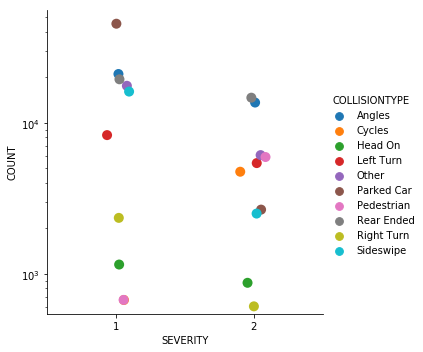

In [103]:
# Draw a catplot to visualize total accidents during various collision types.
df_temp = getcntsinonecol("COLLISIONTYPE")
df_temp.reset_index(inplace=True)
g= sns.catplot(x="SEVERITY", y="COUNT", hue="COLLISIONTYPE", data=df_temp, s=10)
g.set(yscale="log") 

I am just curious on how weather conditions play a role in severity of the collision. Let me figure that out through distribution of collission for each severity under different weather conditions.

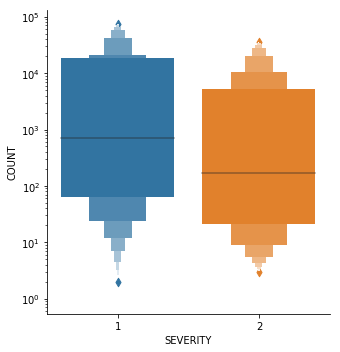

In [24]:
# Draw a box style catplot to visualize the distribution of collisions
# across weather conditions.
df_temp = getcntsinonecol("WEATHER")
g= sns.catplot(x="SEVERITY", y="COUNT", kind="boxen",
            data=df_temp)
g.set(yscale="log") 

Though most of the inputs in the given data set are categorical data, there are a few numeric inputs. Let us check on how they are going to impact the severity code.

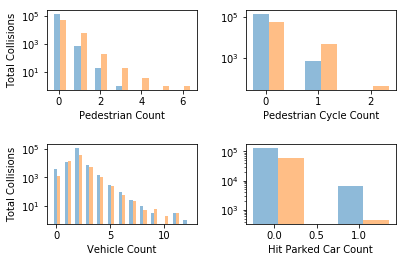

In [25]:
# Plot numerical inputs on bargraph and visualize through subplots
fig,a =  plt.subplots(2,2)

df_t=getseverities('PEDCOUNT')
objects = df_t.index.values
y_pos = np.arange(len(objects))
y1_val = df_t[df_t.columns[0]].values
y2_val = df_t[df_t.columns[1]].values

a[0][0].bar(y_pos-0.1, y1_val, align='center', alpha=0.5,width=0.3)
a[0][0].bar(y_pos+0.2, y2_val, align='center', alpha=0.5,width=0.3)
a[0][0].set_ylabel('Total Collisions')
a[0][0].set_xlabel('Pedestrian Count')
a[0][0].set_yscale('log')

df_t=getseverities('PEDCYLCOUNT')
objects = df_t.index.values
y_pos = np.arange(len(objects))
y1_val = df_t[df_t.columns[0]].values
y2_val = df_t[df_t.columns[1]].values

a[0][1].bar(y_pos-0.1, y1_val, align='center', alpha=0.5,width=0.3)
a[0][1].bar(y_pos+0.2, y2_val, align='center', alpha=0.5,width=0.3)
#a[0][1].set_ylabel('Total Collisions')
a[0][1].set_xlabel('Pedestrian Cycle Count')
a[0][1].set_yscale('log')

df_t=getseverities('VEHCOUNT')
objects = df_t.index.values
y_pos = np.arange(len(objects))
y1_val = df_t[df_t.columns[0]].values
y2_val = df_t[df_t.columns[1]].values

a[1][0].bar(y_pos-0.1, y1_val, align='center', alpha=0.5,width=0.3)
a[1][0].bar(y_pos+0.2, y2_val, align='center', alpha=0.5,width=0.3)
a[1][0].set_ylabel('Total Collisions')
a[1][0].set_xlabel('Vehicle Count')
a[1][0].set_yscale('log')

df_t=getseverities('HITPARKEDCAR')
objects = df_t.index.values
y_pos = np.arange(len(objects))
y1_val = df_t[df_t.columns[0]].values
y2_val = df_t[df_t.columns[1]].values

a[1][1].bar(y_pos-0.1, y1_val, align='center', alpha=0.5,width=0.3)
a[1][1].bar(y_pos+0.2, y2_val, align='center', alpha=0.5,width=0.3)
a[1][1].set_xlabel('Hit Parked Car Count')
a[1][1].set_yscale('log')

fig.tight_layout(pad=2.0)

plt.show()

I also want to check whether the severity differs with the time of the collision. Sometimes, driver may fell drowsy while driving during nights and that can lead to high severity accident. Let me try a visualization.

In [105]:
# Get the hour of the collision from the incident time.
from datetime import datetime
df_time = df[['INCDTTM','SEVERITYCODE']].copy()
df_time['INCDTTM'] = df_time['INCDTTM'].astype('datetime64[ns]')
df_time['HOUR'] = df_time['INCDTTM'].apply(lambda x: x.hour+1)
df_time_cnt = df_time.groupby(['HOUR','SEVERITYCODE'],as_index=True).count()

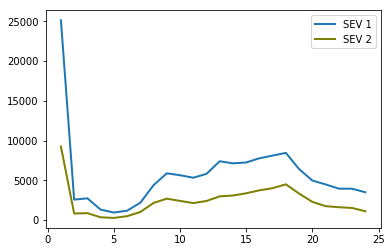

In [114]:
# Plot a graph visualizing the collisions for each hour in a day.
x1 = range(1,25)
y1 = df_time_cnt.query("SEVERITYCODE==1")['INCDTTM']
y2 = df_time_cnt.query("SEVERITYCODE==2")['INCDTTM']
plt.plot(x1, y1, linewidth=2, label = "SEV 1")
plt.plot(x1, y2, color='olive', linewidth=2, label = "SEV 2")
plt.legend()

Lastly, let us look at the ADDRTYPE impact on the severity of the collision

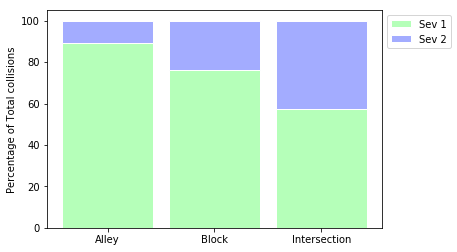

In [198]:
# Draw box plot to identify the %ge difference for each value in ADDRTYPE
df_addr=getseveritiesinpct('ADDRTYPE')
r = range(0,3)
greenBars = df_addr[df_addr.columns[0]].values
blueBars = df_addr[df_addr.columns[1]].values
barWidth = 0.85
names = df_addr.index.values

#Plot the bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth, label="Sev 1")
plt.bar(r, blueBars, bottom=greenBars, color='#a3acff', edgecolor='white', width=barWidth, label="Sev 2")
 
# Custom x axis
plt.xticks(r, names)
plt.ylabel("Percentage of Total collisions")
 
# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
 
# Show graphic
plt.show()

### Pre-Processing - Feature Selection /  Extraction

The data set contains both categorical as well as numerical values. We need to make sure the categorical values are set as str and numerical ones as int.

In [63]:
# Set the data types for numerical and categorical data
X = df_coll.copy()
X.drop(columns="SEVERITYCODE", inplace=True)
X = X.astype(str)
X["PERSONCOUNT"] = X["PERSONCOUNT"].astype(int)
X["PEDCYLCOUNT"] = X["PEDCYLCOUNT"].astype(int)
X["VEHCOUNT"] = X["VEHCOUNT"].astype(int)
X["PEDCOUNT"] = X["PEDCOUNT"].astype(int)
y = df_coll[["SEVERITYCODE"]]
y = y.astype(str)

In [53]:
# Function to transform categorical data in the feature set
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

In [54]:
# Function to transform categorical data in the target variable
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

In [64]:
# Split the data set into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (155738, 13) (155738, 1)
Test (38935, 13) (38935, 1)


In [76]:
# Split the training/test sets further into numerical and categorical date
# pre-processing and normalizing
X_train_num = X_train[['PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']].copy()
X_test_num = X_test[['PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']].copy()

X_train_cat = X_train.copy()
X_train_cat.drop(columns=['PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT'],axis=1,inplace=True)

X_test_cat = X_test.copy()
X_test_cat.drop(columns=['PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT'],axis=1,inplace=True)

X_train_cat_enc, X_test_cat_enc = prepare_inputs(X_train_cat, X_test_cat)
X_train_enc = np.concatenate((X_train_cat_enc,X_train_num.values),axis=1)
X_test_enc = np.concatenate((X_test_cat_enc,X_test_num.values),axis=1)

y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [201]:
# Fit the model into Logistic Regression with the training set
model = LogisticRegression(solver='lbfgs', max_iter=250)
model.fit(X_train_enc, y_train_enc)

# Predict the values using test set
yhat = model.predict(X_test_enc)

print("Logistic Regression")
print("===================")

# Check the accuracy of the predicted values and the target values
accuracy = accuracy_score(y_test_enc, yhat)
print('Accuracy:\t\t %.2f' % (accuracy*100))

jacsim = jaccard_similarity_score(y_test_enc, yhat)
print('Jaccard similarity:\t %.2f' % (jacsim*100))

f1 = f1_score(y_test_enc, yhat, average='weighted')
print('F1 score:\t\t %.2f' % (f1*100))

LR_yhat_prob = model.predict_proba(X_test_enc)
print("LR LogLoss:\t\t %.2f" % log_loss(y_test_enc, LR_yhat_prob))

Logistic Regression
Accuracy:		 75.17
Jaccard similarity:	 75.17
F1 score:		 70.64
LR LogLoss:		 0.51


In [97]:
# Now fit the training set into Decision Tree Classifier
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth=10)
loanTree.fit(X_train_enc, y_train_enc)

# Predict the values using test set
yhat_dt = loanTree.predict(X_test_enc)

print("Decision Tree Classifier")
print("========================")

# Check the accuracy of the predicted values and the target values
accuracy_dt = accuracy_score(y_test_enc, yhat_dt)
print('Decision Tree Accuracy:\t %.2f' % (accuracy_dt*100))

jacsim = jaccard_similarity_score(y_test_enc, yhat_dt)
print('Jaccard similarity:\t %.2f' % (jacsim*100))

f1 = f1_score(y_test_enc, yhat_dt, average='weighted')
print('F1 score:\t\t %.2f' % (f1*100))

Decision Tree Classifier
Decision Tree Accuracy:	 76.24
Jaccard similarity:	 76.24
F1 score:		 72.89


## Results and Discussion <a name="results"></a>

Based on the above analysis, I found that there are very few inputs that are significantly influencing the severity of the collision.

- ADDRTYPE  If the type is Alley or Block then we have better chances of predicting the collision severity as 1.
- ST_COLCODE This is providing a very good insight into severity. There are specific state collision codes in which one of the serverities are very high compared to the other.
- PERSONCOUT, PEDCOUNT, PERSONCOUNT, VEHCOUNT - These numerical features are helping the model to become more accurate. Especially when more people involved in the incident then the chances of the incident becoming high severity are more.
- WEATHER is also playing a role in differentiating the Severities. The median of the Sev 1 collisions is higher compared to Sev 2. 
- COLLISIONTYPE data tells us that there are certain types of collisions for which the severity is consistent. For ex., if the collision type includes pedenstrian or cycle then it is mostly getting into Sev 2 and similarly when the type is sideswip or right turn then it is a Sev 1 collision.

## Conclusion <a name="conclusion"></a>

By predicting the severity of a collision gives the user an ability to look for alternatives when the severity of the collision is high. By using the above information, one can select the route that will take them to the destination safely and reach on time. Public service officials can take advantage of the data and send the right kind of support equipment even before reaching the collision site.